In [1]:
import pandas as pd
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = [6.0, 12.0]
%matplotlib inline
from tqdm import tqdm, trange
from matplotlib.colors import LogNorm
import seaborn as sns

from joblib import Parallel, delayed

## A function to read the rainsensor raw data

We have two sensors named "drop counter" and "condensation detector". Both deliver two numbers every ~1sec:
 * the number of pulses seen in this ~1sec time window
 * the integral pulse width of all pulses within this window (in µs)
 
In order to make reasoning about these numbers easier, we want to combine these 2 values per sensor into one value per sensor. This value should somehow correlate with the magnitude of the rain.

I studied the values of both sensors and found this:

### condensation detector. 

The number of pulses, and the integral length of all pulses, contain exactly the same information, i.e. each pulse has a fixed length so that the integral length is equal to the number of pulses times a certain factor. 
So we can simply throw away the integral length of all pulses, and just think about the number of pulses.

### drop detector.

Here the number of pulses is mostly 1 or zero, but the length of the pulses varies. So here the magnitude is not so much encoded in the number of pulses, but in the integral width. The pulse width varies in rather fixed steps of ~200ms. (actually 2 * 98.404ms has been found to work best). So the integral width of the pulses detected within the integration window of ~1sec is simply divided by ~200ms in order to arrive again at a simple integer number.


One question might be if the drop_detector number and the condensation detector number correlate.

In this step we also perform zero-suppression. So each measurement which contains a zero for both sensors is deleted in order to keep the memory footprint small.


In [2]:
def read_rainsensor_jsonl(path):
    ''' read a fact-magic rainsensor jsonl file and prepare it 
        for convenience:
         * drop columns we do not need
         * drop rows, which are only zeros
         * prepare two columns, one for each sensor, with a number somehow scaling with the "strength" of the rain.
    '''
    NORM_LEN = 2 * 98404. # in us
    df = pd.read_json(path, lines=True) 
    df['cond'] = df.condensation_detector_number_of_pulses
    df['drops'] = df.drop_counter_pulse_length / NORM_LEN
    
    df.drop([
        'condensation_detector_pulse_length',
        'condensation_detector_number_of_pulses',
        'drop_counter_pulse_length',
        'drop_counter_number_of_pulses',
        'time_between_message_updates_in_ms',
        'chksum',
        'time_since_boot_in_ms',
    ], axis=1, inplace=True)
    
    # zero suppression
    df = df[(df.cond != 0) | (df.drops != 0)]
    return df


Here I just loop over all jsonl files and read them in .. and concatenate them.

3 files contained malformated lines, these lines were manually removed.

In [3]:
%%time
df = pd.concat(
    Parallel(n_jobs=-1)(
        delayed(read_rainsensor_jsonl)(path) 
        for path in glob.iglob('jsonl/*')
    )
)

df.set_index('timestamp_utc', inplace=True)
df.sort_index(inplace=True)

CPU times: user 490 ms, sys: 98.6 ms, total: 588 ms
Wall time: 38.3 s


Let's get a little overview ...

In [4]:
df.describe()

,cond,drops
count,864515.000000,864515.000000
mean,1.867783,2.681862
std,2.012381,4.223123
min,0.000000,0.000000
25%,0.000000,0.000000
50%,1.000000,2.002602
75%,4.000000,3.011056
max,9.000000,52.159485


In [5]:
df.index.max() - df.index.min()

Timedelta('254 days 05:40:49.499793')

So we see, we have ~865k non-zero values in 250days. The **drops** go as high as 50, while the **cond**ensation goes only up to 9. Since we did zero suppression it is not surprising to find the median around 1.

Let's have a look at 10 randomly sampled rows, to get an impression how the data looks like:

In [6]:
df.sample(10)

,cond,drops
timestamp_utc,,
2018-01-06 21:07:32.176404,1,8.025223
2017-11-25 18:19:10.812035,5,1.001890
2018-02-06 00:34:55.352396,1,0.000000
2017-11-25 07:33:28.854041,5,2.004614
2018-01-07 09:42:17.042623,3,3.012682
2017-12-12 00:21:11.455560,0,2.006524
2017-11-26 09:42:08.074771,5,10.022113
2017-11-05 10:41:28.648626,0,2.002825
2018-02-02 19:11:26.263984,0,1.003821


## Any correlation? 

Next we want to see, if there is any correlation between the drops and the condensation?

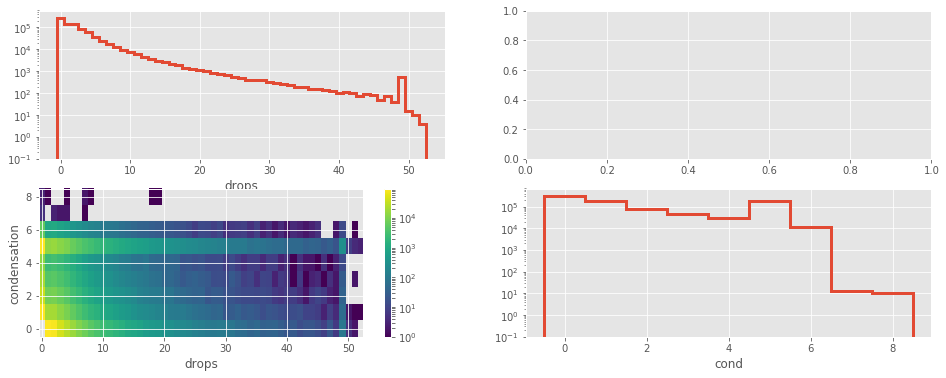

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(16, 6))

X = ax[1, 0].hist2d(
    df.drops, 
    df.cond,
    bins=(
        np.arange(df.drops.max()+1)-0.5,
        np.arange(df.cond.max()+1)-0.5,
    ),
    norm=LogNorm()
)
ax[1,0].set_xlabel('drops')
ax[1,0].set_ylabel('condensation')
plt.colorbar(X[-1], ax=ax[1, 0])

ax[0,0].hist(
    df.drops, 
    bins=np.arange(df.drops.max()+1)-0.5,
    log=True,
    histtype='step',
    lw=3
)
ax[0,0].set_xlabel('drops')

ax[1,1].hist(
    df.cond, 
    bins=np.arange(0, df.cond.max()+1)-0.5,
    log=True,
    histtype='step',
    lw=3
)
ax[1,1].set_xlabel('cond')
None

We see that drops, seems to saturate at values of 50. cond has a saturation like behaviour at 5.

In the 2D histogram we see no clear hint for correlation. 
I assume the sensors might see different amounts of water in any given ~1 sec period. Maybe they correlate better when we **sum** over 30 seconds.

In [8]:
resampled = df.resample('30s').sum().dropna()

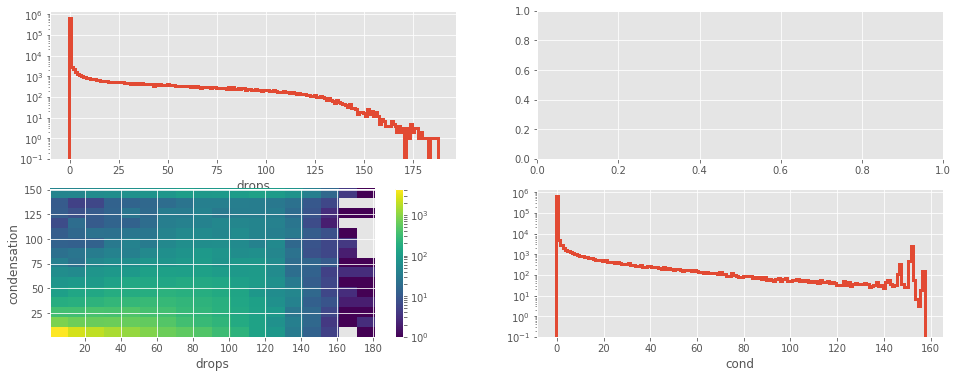

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(16, 6))

X = ax[1, 0].hist2d(
    resampled.drops, 
    resampled.cond,
    bins=(
        np.arange(1, resampled.drops.max()+1, 10),
        np.arange(1, resampled.cond.max()+1, 10),
    ),
    norm=LogNorm()
)
ax[1,0].set_xlabel('drops')
ax[1,0].set_ylabel('condensation')
plt.colorbar(X[-1], ax=ax[1, 0])

ax[0,0].hist(
    resampled.drops, 
    bins=np.arange(0, resampled.drops.max()+1)-0.5,
    log=True,
    histtype='step',
    lw=3
)
ax[0,0].set_xlabel('drops')

ax[1,1].hist(
    resampled.cond, 
    bins=np.arange(0, resampled.cond.max()+1)-0.5,
    log=True,
    histtype='step',
    lw=3
)
ax[1,1].set_xlabel('cond')
None

Ah .. so there might be some correlation ... at least they now cut off both at the same value of roughly 150..160.
From this point on, I only look at the "resampled" data.

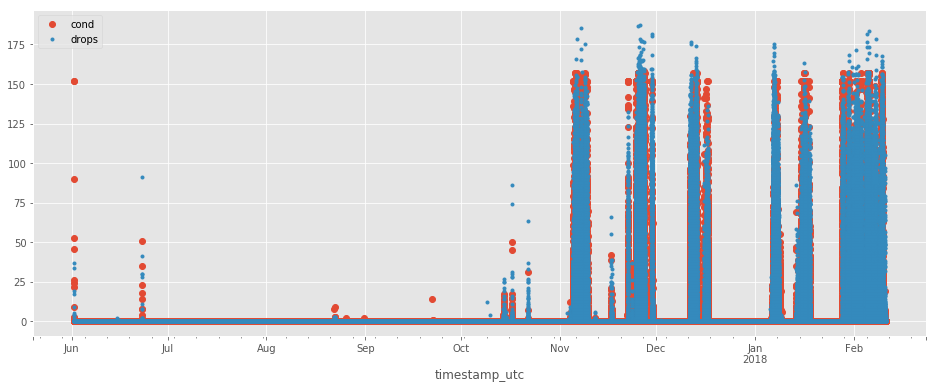

In [10]:
plt.figure(figsize=(16, 6))

resampled.cond.plot(marker='o', lw=0)
resampled.drops.plot(marker='.', lw=0)
plt.legend();

So we see, there was rain several times this year. 

I assume the "rain" between june and july was just testing .. but the rest I don't know.
However the time from november looks interesting, let's have a closer look.

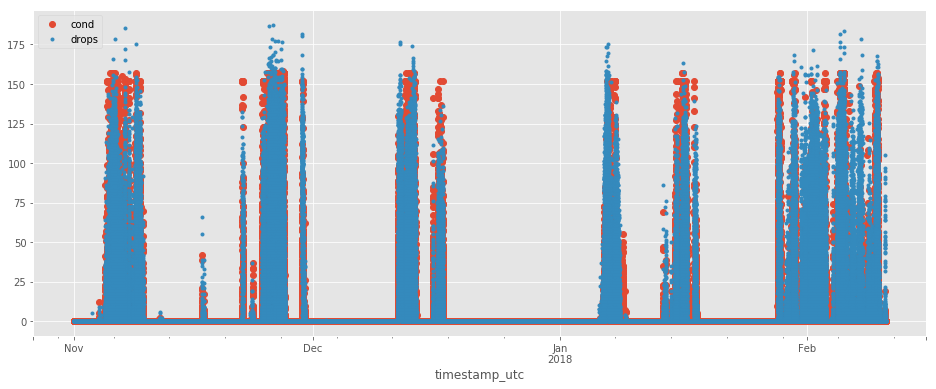

In [11]:
plt.figure(figsize=(16, 6))

resampled["2017-11":].cond.plot(marker='o', lw=0)
resampled["2017-11":].drops.plot(marker='.', lw=0)
plt.legend();

The `cond` seems to be quicker in its reaction... let's further zoom in:

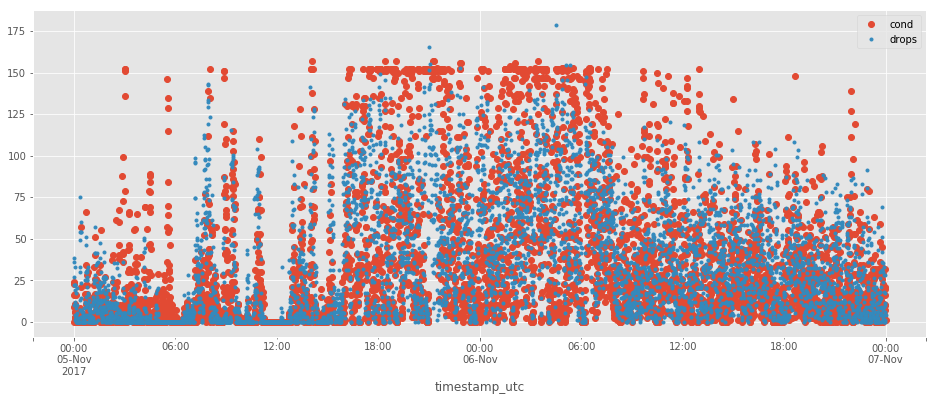

In [12]:
plt.figure(figsize=(16, 6))

resampled["2017-11-05":"2017-11-06"].cond.plot(marker='o', lw=0)
resampled["2017-11-05":"2017-11-06"].drops.plot(marker='.', lw=0)
plt.legend();

So it looks like it rained the entire night of 05.11.2017. Let's have a look if that might be right:
http://fact-project.org/overview_video/2017/11/05/20171105.mp4

Yes .. that was really a rainy night. Let's look at the next day:

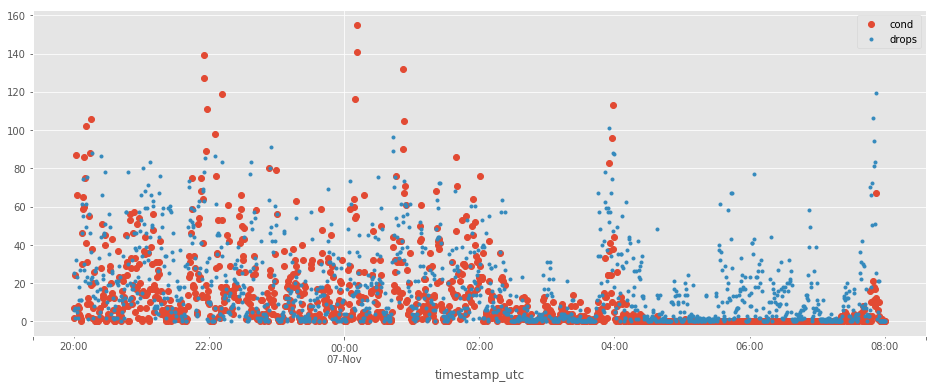

In [13]:
plt.figure(figsize=(16, 6))

s = slice("2017-11-06 20:00", "2017-11-07 08:00")
resampled[s].cond.plot(marker='o', lw=0)
resampled[s].drops.plot(marker='.', lw=0)
plt.legend();

Yes that was also really rainy: http://fact-project.org/overview_video/2017/11/06/20171106.mp4

The next?

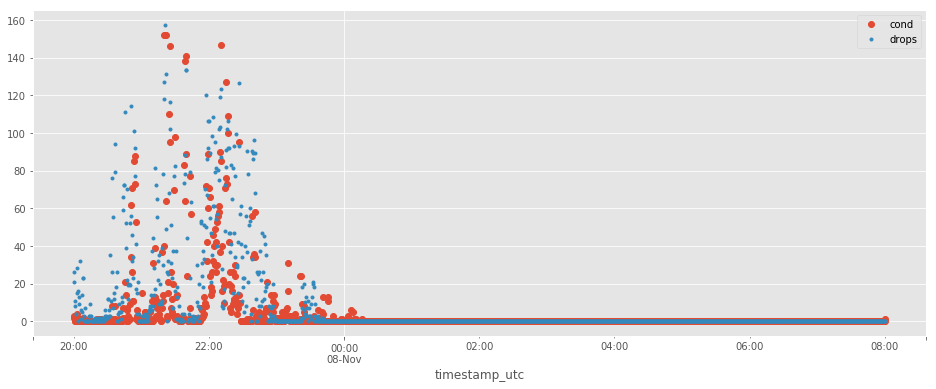

In [14]:
plt.figure(figsize=(16, 6))

s = slice("2017-11-07 20:00", "2017-11-08 08:00")
resampled[s].cond.plot(marker='o', lw=0)
resampled[s].drops.plot(marker='.', lw=0)
plt.legend();

Aha this looks interesting .. so according to the sensors it was rainy until midnight ... and good after that.

Looks roughly plausible ... the next?


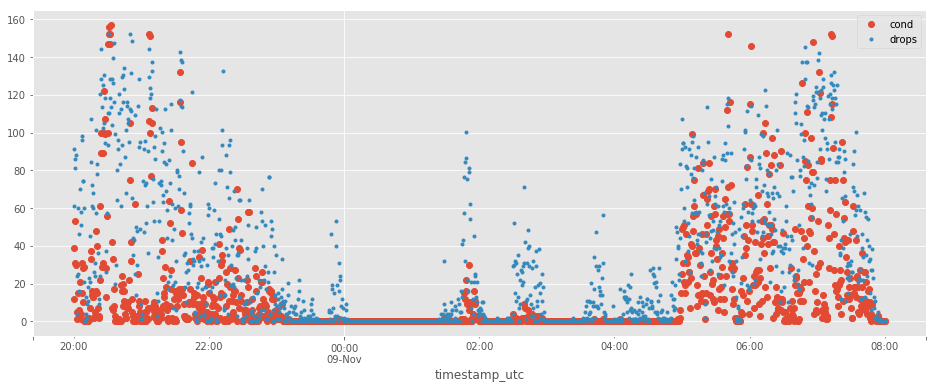

In [15]:
plt.figure(figsize=(16, 6))

s = slice("2017-11-08 20:00", "2017-11-09 08:00")
resampled[s].cond.plot(marker='o', lw=0)
resampled[s].drops.plot(marker='.', lw=0)
plt.legend();

Yes looks also plausible from the video...

let's jump to the 11th

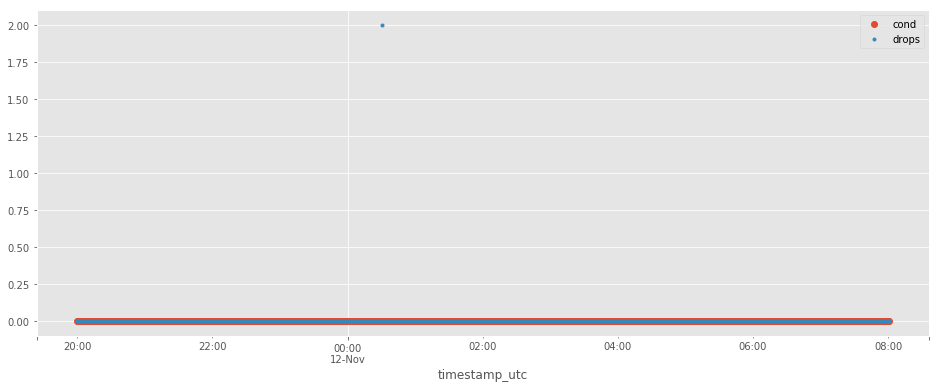

In [16]:
plt.figure(figsize=(16, 6))

s = slice("2017-11-11 20:00", "2017-11-12 8:00")
resampled[s].cond.plot(marker='o', lw=0)
resampled[s].drops.plot(marker='.', lw=0)
plt.legend();

Aha . . so it rained .. exactly for 30sec .. half past midnight. but we don't see any hint for that in the video:

http://fact-project.org/overview_video/2017/11/11/20171111.mp4

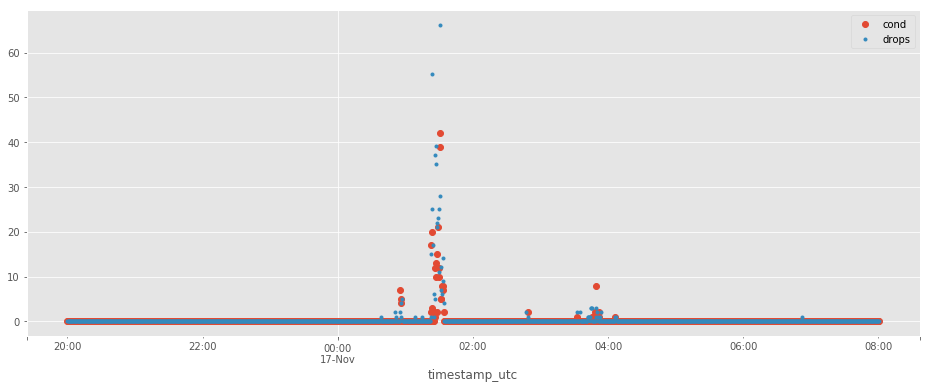

In [17]:
plt.figure(figsize=(16, 6))

s = slice("2017-11-16 20:00", "2017-11-17 8:00")
resampled[s].cond.plot(marker='o', lw=0)
resampled[s].drops.plot(marker='.', lw=0)
plt.legend();

This is the night mentioned by the magic shifters:
```
     [2017-11-17 01:40:57]
     We realized a few mins back that it started raining. We saw also
     raindrops on the
     AllSkyCamera although humidity was low and no rain warnings.

     [2017-11-17 03:54:34]
     We then re-pointed to G150_W2, but cloudiness was 100% and
     transmission@9km 0.13.
     We went to check outside and saw that it was raining again. 
```

And indeed it was also possible to identify this rain in the fact overview video:
http://fact-project.org/overview_video/2017/11/16/20171116.mp4

### Final "rain parameter"

Looking at the plots, it seems that we do not need two different parameters "cond" and "drops" in order to see if it rains, or not. Since these parameters seem to scale similarly (when resampled to 30 sec integration windows), I would propose to introduce the "rain parameter" simply as the maximum of "drops" and "cond".

In [18]:
resampled['rain'] = resampled.max(axis=1)

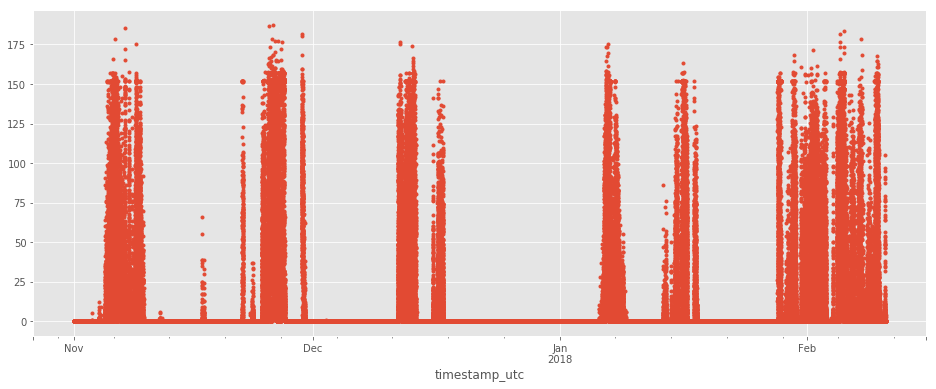

In [19]:
plt.figure(figsize=(16, 6))
resampled["2017-11":].rain.plot(marker='.', lw=0);

It would be nice to somehow normalize this parameter. Maybe to the range [0..1] or [0..100] and display this number on the MAGIC weather page. It looks like the maximum value over this last heavy rain period never exceeded 200. So simply dividing by 2 might lead to a value which is positive and maybe never exceeds 100. 

I think that is something we can maybe live with.

# Normalizing to 0 .. 100

In [20]:
resampled /= 2

In [21]:
resampled.describe()

,cond,drops,rain
count,732203.000000,732203.000000,732203.000000
mean,1.102649,1.583243,1.925263
std,7.095623,7.638303,9.179325
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,79.000000,93.695023,93.695023


Looking at the time from 2017-11-11 20:00 until 2017-11-12 8:00 we see this single value, which was at rain=1 for one sample (=30seconds). I think this gives us a feeling for a lower limit, i.e. we could say if rain <= 1 we call it dry. 

However in the night of the 16th Nov 2017, the shifters reported about rain, while the rain value was not even 4, so maybe we can really everything above 1 is really rain.

However time is of course also important, when the value is around 4 for 3 minutes it is maybe not a reason to close the lid and park ... but who knows .. it might get worse soon.

(0, 10)

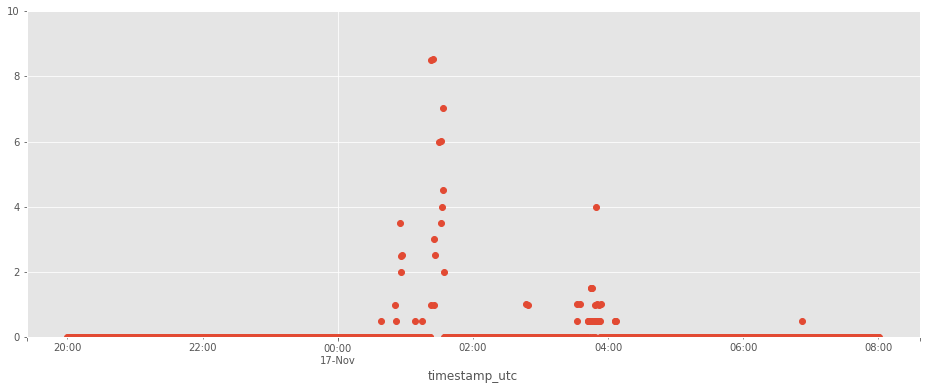

In [22]:
plt.figure(figsize=(16, 6))
resampled["2017-11-16 20:00":"2017-11-17 8:00"].rain.plot(marker='o', lw=0);
plt.ylim(0, 10)